<a href="https://colab.research.google.com/github/Asad1287/AntiFractals/blob/main/Outlier_Timeseries_Detection_using_AntiFractal_Sets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from typing import Tuple, Union, Literal

@numba.njit
def _qc(z: complex, m: int, c: complex) -> complex:
    z = z.conjugate()
    return np.power(z, m) - np.power(z, 1) + c

@numba.njit
def _boundary_limit(mu: float, s: float, a: float) -> float:
    return (mu - abs(s*a))/(abs(s*a))

@numba.njit
def get_iter_frac(c: complex, m: int, max_steps: int, alpha1: float,
                 alpha2: float, alpha3: float, s: float) -> int:
    z = 0.5
    i = 0
    R = max(abs(c),
           _boundary_limit(2,s,alpha1),
           _boundary_limit(2,s,alpha2),
           _boundary_limit(2,s,alpha3))

    while i < max_steps:
        z = _qc(z,m,c)
        wn = np.power((1-alpha3),s)*z + np.power((alpha3),s)*_qc(z,m,c)
        vn = np.power((1-alpha2),s)*_qc(z,m,c) + np.power((alpha2),s)*_qc(wn,m,c)
        z = np.power((1-alpha1),s)*vn + np.power((alpha1),s)*_qc(vn,m,c)

        if abs(z) > R:
            break
        i += 1
    return i

@numba.njit
def get_iter_julia(z: complex, c: complex, m: int, max_steps: int,
                  alpha1: float, alpha2: float, alpha3: float, s: float) -> int:
    i = 0
    R = max(abs(c),
           _boundary_limit(2,s,alpha1),
           _boundary_limit(2,s,alpha2),
           _boundary_limit(2,s,alpha3))

    while i < max_steps:
        z = _qc(z,m,c)
        wn = np.power((1-alpha3),s)*z + np.power((alpha3),s)*_qc(z,m,c)
        vn = np.power((1-alpha2),s)*_qc(z,m,c) + np.power((alpha2),s)*_qc(wn,m,c)
        z = np.power((1-alpha1),s)*vn + np.power((alpha1),s)*_qc(vn,m,c)

        if abs(z) > R:
            break
        i += 1
    return i

@numba.njit
def generate_fractal(n: int, m: int, max_steps: int, fractal_type: int,
                    alpha1: float, alpha2: float, alpha3: float, s: float) -> np.ndarray:
    mx = 3.48 / (n-1)
    my = 3.48 / (n-1)
    img = np.full((n,n), 255)

    for x in range(n):
        for y in range(n):
            real = mx*x - 1.7
            imag = my*y - 1.7
            if fractal_type == 0:  # Julia
                it = get_iter_julia(complex(real,imag), complex(0.2,-0.2),
                                  m, max_steps, alpha1, alpha2, alpha3, s)
            else:  # AntiFrac
                it = get_iter_frac(complex(real,imag), m, max_steps,
                                 alpha1, alpha2, alpha3, s)
            img[y][x] = 255 - it
    return img

class FractalGenerator:
    def __init__(self):
        self.alpha1 = 0.1
        self.alpha2 = 0.1
        self.alpha3 = 0.1

    def generate(self, n: int, m: int, max_steps: int,
                fractal_type: Literal['Julia', 'AntiFrac'],
                alpha1: float = 0.1, alpha2: float = 0.1,
                alpha3: float = 0.1, s: float = 0.5) -> np.ndarray:
        type_int = 0 if fractal_type == 'Julia' else 1
        return generate_fractal(n, m, max_steps, type_int, alpha1, alpha2, alpha3, s)

    @staticmethod
    def fractal_dimension(Z: np.ndarray, threshold: float = 0.9) -> float:
        assert len(Z.shape) == 2, "Input must be 2D array"

        def boxcount(Z: np.ndarray, k: int) -> int:
            S = np.add.reduceat(
                np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                np.arange(0, Z.shape[1], k), axis=1)
            return len(np.where((S > 0) & (S < k*k))[0])

        Z = (Z < threshold)
        p = min(Z.shape)
        n = int(np.log(2**np.floor(np.log(p)/np.log(2)))/np.log(2))
        sizes = 2**np.arange(n, 1, -1)

        counts = [boxcount(Z, size) for size in sizes]
        coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
        return -coeffs[0]

    def analyze_fractal(self, img: np.ndarray) -> Tuple[float, float, int]:
        return np.var(img), len(np.unique(img)), self.fractal_dimension(img/256.0)

    def plot_fractal(self, img: np.ndarray, filename: str = None) -> None:
        plt.figure(figsize=(2.56, 2.58))
        plt.imshow(img, cmap='nipy_spectral')
        plt.axis("off")
        if filename:
            plt.savefig(filename)
        plt.close()


This document explains the mathematical foundations of the Python code that generates fractal images and computes the Minkowski--Bouligand (box-counting) fractal dimension. Two types of fractals are considered:
\begin{itemize}
    \item \textbf{Julia}-type fractals.
    \item \textbf{AntiFrac}-type fractals.
\end{itemize}
The iterative process, boundary limits, and box-counting dimension are described below.

\section{The Iteration Function and Parameters}

We consider a complex function:
\[
Q_c(z,m,c) \;=\; \overline{z}^m \;-\; \overline{z} \;+\; c,
\]
where:
\begin{itemize}
    \item \(z \in \mathbb{C}\) is the state of iteration,
    \item \(\overline{z}\) denotes the complex conjugate of \(z\),
    \item \(m \in \mathbb{N}\) is an integer exponent (e.g., \(m=2\)),
    \item \(c \in \mathbb{C}\) is a constant complex parameter.
\end{itemize}

In the code, \(\_qc\) is defined by:
\[
\_qc(z,m,c) = Q_c(z,m,c).
\]

\subsection{Boundary Limit Function}
A function
\[
\text{boundary\_limit}(\mu, s, a) \;=\; \frac{\mu \;-\; \lvert s \, a \rvert}{\lvert s \, a \rvert}
\]
helps to compute an upper bound \(R\) so that if \(\lvert z \rvert > R\), we declare that the iteration has ``escaped.''

\subsection{Iterative Updates}
Two iterative functions appear in the code:

\begin{enumerate}
    \item \(\text{get\_iter\_frac}(c, m, \text{max\_steps}, \alpha_1, \alpha_2, \alpha_3, s)\)
    \item \(\text{get\_iter\_julia}(z, c, m, \text{max\_steps}, \alpha_1, \alpha_2, \alpha_3, s)\)
\end{enumerate}

\subsubsection{AntiFrac Iteration}
Starting with \(z_0 = 0.5\), at each step:
\[
\begin{aligned}
1.\quad & z_{n+1}' = Q_c\bigl(z_n, m, c\bigr),\\
2.\quad & w_n = (1-\alpha_3)^s \, z_{n+1}' \;+\; (\alpha_3)^s \, Q_c\bigl(z_{n+1}', m, c\bigr),\\
3.\quad & v_n = (1-\alpha_2)^s \, Q_c\bigl(z_{n+1}', m, c\bigr) \;+\; (\alpha_2)^s \, Q_c\bigl(w_n, m, c\bigr),\\
4.\quad & z_{n+1} = (1-\alpha_1)^s \, v_n \;+\; (\alpha_1)^s \, Q_c\bigl(v_n, m, c\bigr).
\end{aligned}
\]

We repeat up to \(\text{max\_steps}\) or until \(\lvert z_{n+1} \rvert > R\).

\subsubsection{Julia Iteration}
Here, the code is similar but starts with an initial \(\,z_0\,\) from the pixel coordinate \((x,y)\). We iterate the same sequence of transformations:
\[
\begin{aligned}
& z_{n+1}' = Q_c\bigl(z_n, m, c\bigr), \quad \text{then use the same }w_n, v_n, \text{ and final }z_{n+1} \text{ steps as above.}
\end{aligned}
\]

\section{Generating the Fractal Image}
To produce a 2D image of resolution \(n \times n\), we map each pixel \((x, y)\) to a point in the complex plane:
\[
\text{real} = \text{mx} \cdot x - 1.7,\quad
\text{imag} = \text{my} \cdot y - 1.7,
\]
where
\[
\text{mx} = \frac{3.48}{n-1},
\quad
\text{my} = \frac{3.48}{n-1}.
\]
We then call the appropriate iteration function (Julia or AntiFrac) to determine how many steps it takes before the sequence escapes. This iteration count is stored in the final image array.

\section{Fractal Dimension (Minkowski--Bouligand)}

The fractal code also estimates the box-counting dimension (often called the Minkowski--Bouligand dimension). If \(Z\) is a 2D array (image), it is first converted into a binary matrix:
\[
Z_{\text{binary}}(i,j) \;=\;
\begin{cases}
1 & \text{if } Z(i,j) < \text{threshold},\\
0 & \text{otherwise}.
\end{cases}
\]

\subsection{Box-Counting Method}

We choose a series of box sizes \(k \in \{2^n, 2^{n-1}, \ldots, 2^1\}\). For each \(k\), we:
\begin{enumerate}
    \item Partition the image into non-overlapping blocks of size \(k \times k\).
    \item For each block, compute the sum of pixel values in that block:
    \[
    S_k(\ell) = \sum_{\substack{(i,j)\,\in\,\text{block } \ell}} Z_{\text{binary}}(i,j).
    \]
    \item Count the number of partially filled blocks, i.e.~those with sums strictly between \(0\) and \(k^2\):
    \[
    \text{boxcount}(Z, k) = \#\left\{\, \ell : 0 < S_k(\ell) < k^2 \,\right\}.
    \]
\end{enumerate}

Then, we fit a line in log-log scale:
\[
\ln(\text{boxcount}(Z, k)) \;\approx\; -D \,\ln(k) + b,
\]
so that
\[
D \;=\; - \text{slope} \;=\; -\beta,\quad \text{where } \beta \text{ is the slope of the linear fit.}
\]

\section{Summary}
This LaTeX document provides a mathematical description of:
\begin{itemize}
    \item The iterative functions that generate the fractal images.
    \item The boundary and stopping criteria.
    \item The box-counting algorithm for fractal dimension.
\end{itemize}
These formulas underlie the Python code, enabling both fractal generation (Julia/AntiFrac) and fractal dimension estimation.

\end{document}


In [2]:
generator = FractalGenerator()
s_values = [0.001, 0.1, 0.3, 0.5, 0.7, 0.999]

for s in s_values:
    img = generator.generate(1000, 3, 50, 'Julia', s=s)
    variance, colors, dimension = generator.analyze_fractal(img)
    generator.plot_fractal(img, f'quadcorn_quad_{s}.jpg')

<ipython-input-1-35f6a0d838fa>:105: RuntimeWarning: divide by zero encountered in log
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
<ipython-input-1-35f6a0d838fa>:105: RuntimeWarning: divide by zero encountered in log
  coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)


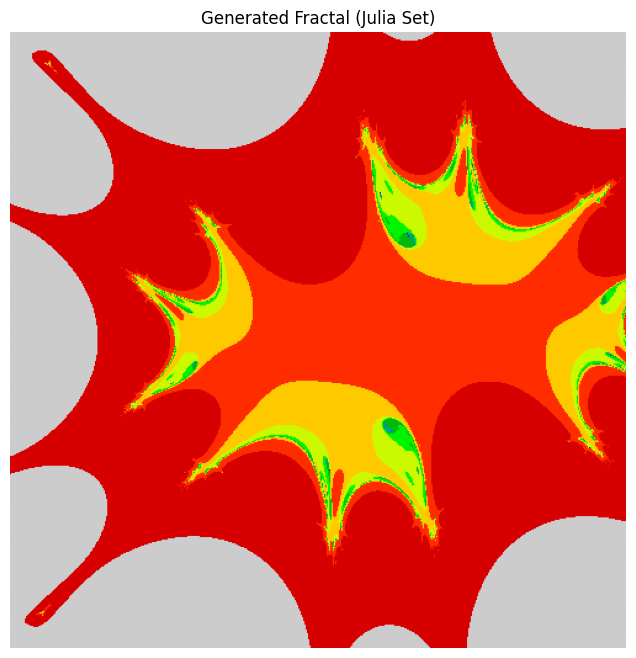

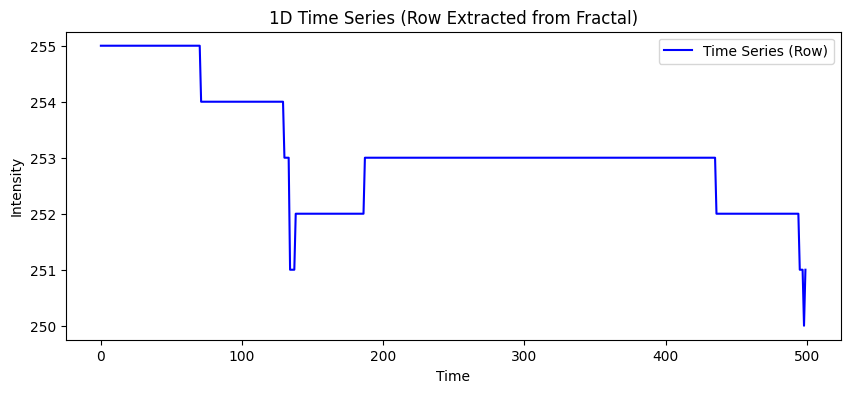

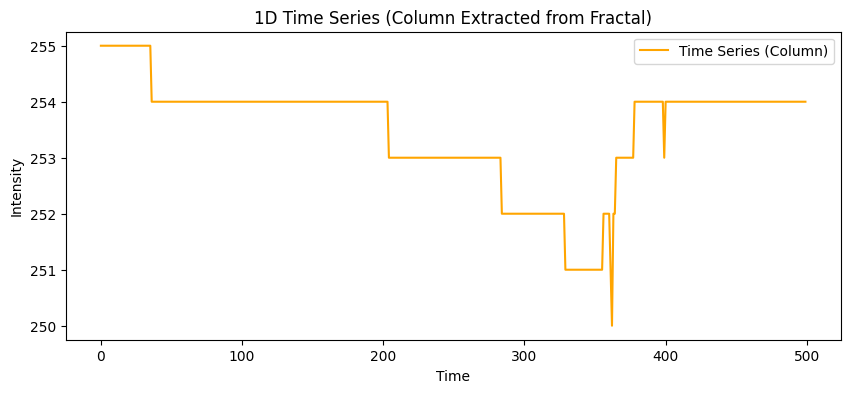

In [3]:
# Create a fractal generator instance
fractal_gen = FractalGenerator()

# Generate a fractal image
n = 500  # Image size
m = 2    # Power in the fractal function
max_steps = 50  # Max iterations
alpha1, alpha2, alpha3 = 0.1, 0.1, 0.1
s = 0.5  # Scaling parameter

# Generate a fractal image of type 'Julia' or 'AntiFrac'
fractal_img = fractal_gen.generate(n, m, max_steps, fractal_type='Julia', alpha1=alpha1, alpha2=alpha2, alpha3=alpha3, s=s)

# Extract time series from rows or columns
time_series_row = fractal_img[n // 2, :]  # Take the middle row as a 1D time series
time_series_col = fractal_img[:, n // 2]  # Take the middle column as another 1D time series
# Plot the fractal image
plt.figure(figsize=(8, 8))
plt.title("Generated Fractal (Julia Set)")
plt.imshow(fractal_img, cmap='nipy_spectral')
plt.axis("off")
plt.show()

# Plot the extracted 1D time series (row)
plt.figure(figsize=(10, 4))
plt.title("1D Time Series (Row Extracted from Fractal)")
plt.plot(time_series_row, label="Time Series (Row)", color="blue")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.legend()
plt.show()

# Plot the extracted 1D time series (column)
plt.figure(figsize=(10, 4))
plt.title("1D Time Series (Column Extracted from Fractal)")
plt.plot(time_series_col, label="Time Series (Column)", color="orange")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.legend()


## Running Outlier Detection using Fractal timeseries Analysis

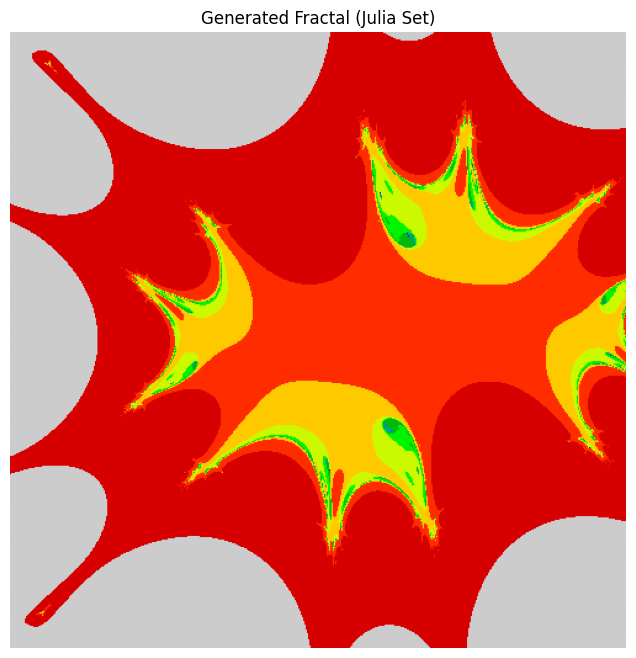

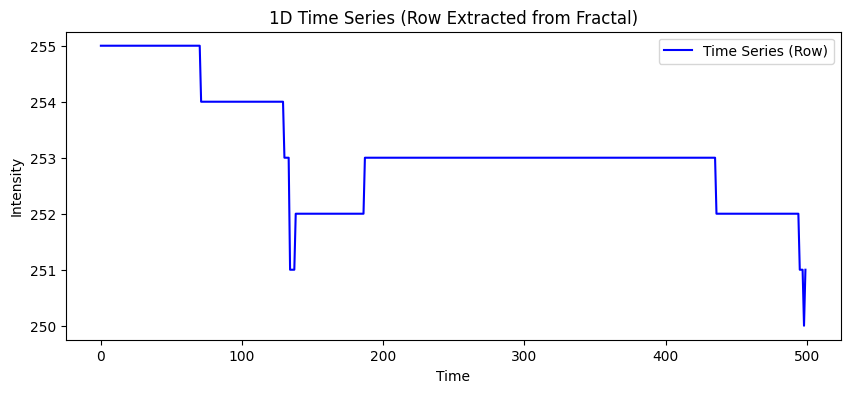

Fractal Dimension: 0.757
Hurst Exponent: 1.243


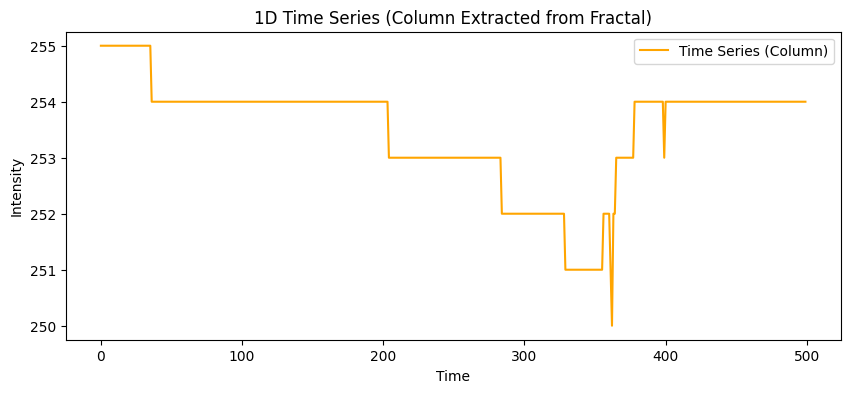

In [4]:
import numpy as np
import numba
from typing import Tuple

@numba.njit
def normalize_timeseries(x: np.ndarray) -> np.ndarray:
    """Normalize time series to [0,1] range"""
    min_x = np.min(x)
    max_x = np.max(x)
    return (x - min_x) / (max_x - min_x)

@numba.njit
def create_2d_grid(x: np.ndarray, num_bins: int) -> Tuple[np.ndarray, np.ndarray]:
    """Transform 1D time series to 2D grid points"""
    normalized = normalize_timeseries(x)
    time = np.linspace(0, 1, len(x))

    # Discretize into bins
    time_bins = np.floor(time * num_bins).astype(np.int32)
    value_bins = np.floor(normalized * num_bins).astype(np.int32)

    return time_bins, value_bins

@numba.njit
def count_boxes(time_bins: np.ndarray, value_bins: np.ndarray,
                box_size: int, num_bins: int) -> int:
    """Count number of boxes needed to cover the points"""
    grid = np.zeros((num_bins // box_size + 1,
                    num_bins // box_size + 1), dtype=np.int32)

    for t, v in zip(time_bins, value_bins):
        grid[t // box_size, v // box_size] = 1

    return np.sum(grid)

@numba.njit
def compute_box_counts(x: np.ndarray, min_size: int = 2,
                      max_size: int = 64) -> Tuple[np.ndarray, np.ndarray]:
    """Compute box counts for different box sizes"""
    num_bins = max_size * 2  # Ensure enough resolution
    time_bins, value_bins = create_2d_grid(x, num_bins)

    # Generate box sizes as powers of 2
    box_sizes = np.array([2**i for i in range(int(np.log2(min_size)),
                                            int(np.log2(max_size)) + 1)])
    counts = np.zeros_like(box_sizes, dtype=np.float64)

    for i, size in enumerate(box_sizes):
        counts[i] = count_boxes(time_bins, value_bins, size, num_bins)

    # Compute log values
    log_sizes = np.log(1.0 / box_sizes)
    log_counts = np.log(counts)

    return log_sizes, log_counts

@numba.njit
def fit_line(x: np.ndarray, y: np.ndarray) -> float:
    """Compute slope of line using linear regression"""
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x * y)
    sum_xx = np.sum(x * x)

    slope = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x)
    return slope

@numba.njit
def compute_fractal_dimension(x: np.ndarray) -> float:
    """Compute fractal dimension of time series using box-counting"""
    log_sizes, log_counts = compute_box_counts(x)
    dimension = fit_line(log_sizes, log_counts)
    return dimension

@numba.njit
def compute_hurst_exponent(x: np.ndarray) -> float:
    """Compute Hurst exponent from fractal dimension"""
    D = compute_fractal_dimension(x)
    return 2.0 - D

def analyze_timeseries_complexity(x: np.ndarray) -> Tuple[float, float]:
    """Analyze time series complexity using fractal metrics

    Args:
        x: Input time series data

    Returns:
        Tuple of (fractal_dimension, hurst_exponent)
    """
    D = compute_fractal_dimension(x)
    H = 2.0 - D
    return D, H

# Example usage
if __name__ == "__main__":
    # Generate sample fractional Brownian motion
    fractal_gen = FractalGenerator()

    # Generate a fractal image
    n = 500  # Image size
    m = 2    # Power in the fractal function
    max_steps = 50  # Max iterations
    alpha1, alpha2, alpha3 = 0.1, 0.1, 0.1
    s = 0.5  # Scaling parameter

    # Generate a fractal image of type 'Julia' or 'AntiFrac'
    fractal_img = fractal_gen.generate(n, m, max_steps, fractal_type='Julia', alpha1=alpha1, alpha2=alpha2, alpha3=alpha3, s=s)

    # Extract time series from rows or columns
    time_series_row = fractal_img[n // 2, :]  # Take the middle row as a 1D time series
    time_series_col = fractal_img[:, n // 2]  # Take the middle column as another 1D time series
    # Plot the fractal image
    plt.figure(figsize=(8, 8))
    plt.title("Generated Fractal (Julia Set)")
    plt.imshow(fractal_img, cmap='nipy_spectral')
    plt.axis("off")
    plt.show()

    # Plot the extracted 1D time series (row)
    plt.figure(figsize=(10, 4))
    plt.title("1D Time Series (Row Extracted from Fractal)")
    plt.plot(time_series_row, label="Time Series (Row)", color="blue")
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.legend()
    plt.show()

    # Plot the extracted 1D time series (column)
    plt.figure(figsize=(10, 4))
    plt.title("1D Time Series (Column Extracted from Fractal)")
    plt.plot(time_series_col, label="Time Series (Column)", color="orange")
    plt.xlabel("Time")
    plt.ylabel("Intensity")
    plt.legend()

    D, H = analyze_timeseries_complexity(time_series_col)
    print(f"Fractal Dimension: {D:.3f}")
    print(f"Hurst Exponent: {H:.3f}")

In [ ]:
import numpy as np
import numba
from typing import Tuple, List


def segment_timeseries(x: np.ndarray, n_segments: int) -> List[np.ndarray]:
    """Split time series into n equal segments"""
    segment_length = len(x) // n_segments
    return [x[i*segment_length:(i+1)*segment_length] for i in range(n_segments)]


def compute_segment_metrics(segment: np.ndarray, min_size: int = 2,
                          max_size: int = 32) -> Tuple[float, float]:
    """Compute H and D for a single segment"""
    log_sizes, log_counts = compute_box_counts(segment)
    D = fit_line(log_sizes, log_counts)
    H = 2.0 - D
    return H, D


def analyze_segments(time_series: np.ndarray, n_segments: int) -> Tuple[np.ndarray, np.ndarray]:
    """Analyze each segment and return arrays of H and D values"""
    segments = segment_timeseries(time_series, n_segments)
    H_values = np.zeros(n_segments)
    D_values = np.zeros(n_segments)

    for i, segment in enumerate(segments):
        H_values[i], D_values[i] = compute_segment_metrics(segment)

    return H_values, D_values

# Example usage
if __name__ == "__main__":
    # Generate fractal time series
    fractal_gen = FractalGenerator()
    img = fractal_gen.generate(1000, 2, 50, 'Julia')
    time_series = img[500, :].astype(np.float64)  # Middle row

    # Analyze segments
    H_values, D_values = analyze_segments(time_series, 50)

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.subplot(311)
    plt.plot(time_series)
    plt.title('Original Time Series')

    plt.subplot(312)
    plt.plot(H_values, 'r-')
    plt.title('Hurst Exponent by Segment')

    plt.subplot(313)
    plt.plot(D_values, 'g-')
    plt.title('Fractal Dimension by Segment')
    plt.tight_layout()
    plt.show()

    print("Average H:", np.mean(H_values))
    print("Average D:", np.mean(D_values))